### Load

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from xen.visualise import plotPart, plotSparseNoteSequence

In [1]:
from xen.data.SongData import SongDataSet

data_dir = "../../../ai/trainingdata/music/800000_Drum_Percussion_MIDI_Archive/Rock-Indie"

dataset = SongDataSet()
dataset.loadMidiDir(data_dir, recursive=True)


Loading 268 files


IntProgress(value=0, max=268)

Label(value='')

Loaded 268 songs


### Filter

In [3]:
dataset = dataset.filterTimeSig('4/4')

Filtered to 421 songs


###  Encode

In [4]:
from xen.codecs.NoteSequenceFlatCodec import NoteSequenceFlatCodec

ticksPerQuarter = 4   # 4 = 16th notes, to allow triplets would need to be 12 = 48 per measure
quartersPerMeasure = 4
measuresPerSequence = 1

codec = NoteSequenceFlatCodec(ticksPerQuarter, quartersPerMeasure, measuresPerSequence, '4/4', trim = True, compress=False)
codec.encodeAll(dataset)




Ignored 4 sequences from ../../../ai/trainingdata/music/800000_Drum_Percussion_MIDI_Archive/Electronic Dance/2012 - 5PM - Trance MIDI/SNARE_FILLS & ROLLS/TF2_Snare FIll10.mid
Ignored 1 sequences from ../../../ai/trainingdata/music/800000_Drum_Percussion_MIDI_Archive/Electronic Dance/2012 - 5PM - Trance MIDI/SNARE_FILLS & ROLLS/TF2_Snare Roll20.mid
Ignored 1 sequences from ../../../ai/trainingdata/music/800000_Drum_Percussion_MIDI_Archive/Electronic Dance/2012 - 5PM - Trance MIDI/SNARE_FILLS & ROLLS/TF2_Snare Roll18.mid
Ignored 2 sequences from ../../../ai/trainingdata/music/800000_Drum_Percussion_MIDI_Archive/Electronic Dance/2012 - 5PM - Trance MIDI/SNARE_FILLS & ROLLS/TF2_Snare Roll14.mid
Ignored 1 sequences from ../../../ai/trainingdata/music/800000_Drum_Percussion_MIDI_Archive/Electronic Dance/2012 - 5PM - Trance MIDI/SNARE_FILLS & ROLLS/TF2_Snare Roll5.mid
Ignored 1 sequences from ../../../ai/trainingdata/music/800000_Drum_Percussion_MIDI_Archive/Electronic Dance/2012 - 5PM - Tran

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from xen.models.VariationalAutoencoder import VariationalAutoEncoder

# calculate layer dimensions as a reduction by equal factor
inputDim = dataset.sequences.shape[1]
latentDim = 4
dimDivider = (dataset.sequences.shape[1] // latentDim) ** (1./3.)
layerDims = [inputDim, int(inputDim/dimDivider), int(inputDim/dimDivider**2), latentDim]
print(f'Layer dims: {layerDims}')

autoencoder = VariationalAutoEncoder(layerDims=layerDims, name='drums_50s_4-4', path="../models")
autoencoder.compile(optimizer=Adam(learning_rate=0.005))

2023-06-05 13:32:58.866278: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Layer dims: [992, 157, 25, 4]
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 992)]        0           []                               
                                                                                                  
 encoder_internal_0 (Dense)     (None, 157)          155901      ['encoder_input[0][0]']          
                                                                                                  
 encoder_internal_1 (Dense)     (None, 25)           3950        ['encoder_internal_0[0][0]']     
                                                                                                  
 encoder_mean (Dense)           (None, 4)            104         ['encoder_internal_1[0][0]']     
                                                              

### Train

In [6]:


autoencoder.train(dataset.sequences, batchSize = 32, epochs = 500)


Train on 1299 samples
Epoch 1/500
1299/1299 [==============================] - 0s 203us/sample - loss: 16.6187
Epoch 2/500
1299/1299 [==============================] - 0s 174us/sample - loss: 16.7807
Epoch 3/500
1299/1299 [==============================] - 0s 230us/sample - loss: 17.4541
Epoch 4/500
1299/1299 [==============================] - 0s 154us/sample - loss: 17.2170
Epoch 5/500
1299/1299 [==============================] - 0s 157us/sample - loss: 16.8154
Epoch 6/500
1299/1299 [==============================] - 0s 157us/sample - loss: 16.5586
Epoch 7/500
1299/1299 [==============================] - 0s 162us/sample - loss: 17.0053
Epoch 8/500
1299/1299 [==============================] - 0s 160us/sample - loss: 16.5374
Epoch 9/500
1299/1299 [==============================] - 0s 147us/sample - loss: 16.8919
Epoch 10/500
1299/1299 [==============================] - 0s 145us/sample - loss: 17.0300
Epoch 11/500
1299/1299 [==============================] - 0s 167us/sample - loss: 16.77

In [7]:


def countMatches(indata, outdata):
    matches = 0
    for i in range(0, len(indata)):
        insequence = indata[i]
        outsequence = outdata[i]
        match = True
        for j in range(len(insequence)):
            if ((insequence[j] >= 0.5 and outsequence[j] < 0.5) or (insequence[j] < 0.5 and outsequence[j] >= 0.5)):
                match = False
                # print(i)
        if (match):
            matches = matches + 1
    return matches
    

output = autoencoder.predict(dataset.sequences)

matches = countMatches(dataset.sequences, output)
print(f'{matches/len(dataset.sequences)*100}% recall')



/Users/rob/anaconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-05-28 13:34:45.877364: W tensorflow/c/c_api.cc:300] Operation '{name:'decoder/decoder_output/Sigmoid' id:207 op device:{requested: '', assigned: ''} def:{{{node decoder/decoder_output/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](decoder/decoder_output/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


40.64665127020785% recall


### Visualise Latent Space

2023-05-28 13:34:56.082996: W tensorflow/c/c_api.cc:300] Operation '{name:'encoder_mean/BiasAdd' id:73 op device:{requested: '', assigned: ''} def:{{{node encoder_mean/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](encoder_mean/MatMul, encoder_mean/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


[-0.7681756  -0.4291893  -0.48859385 ... -0.48057738 -0.51335883
 -0.5453446 ]


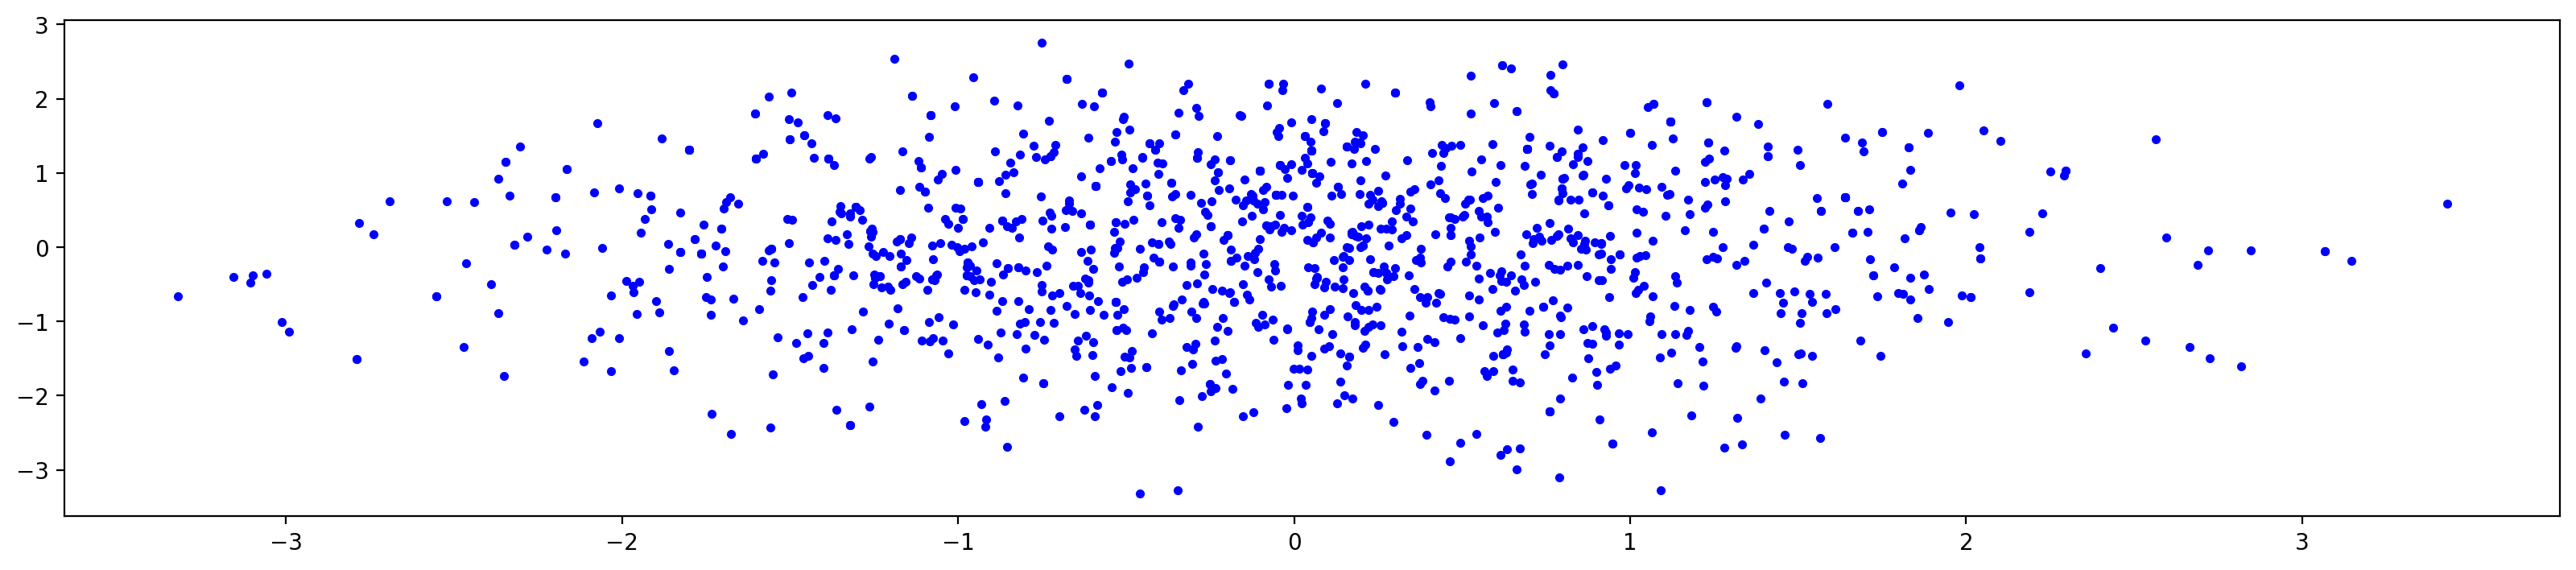

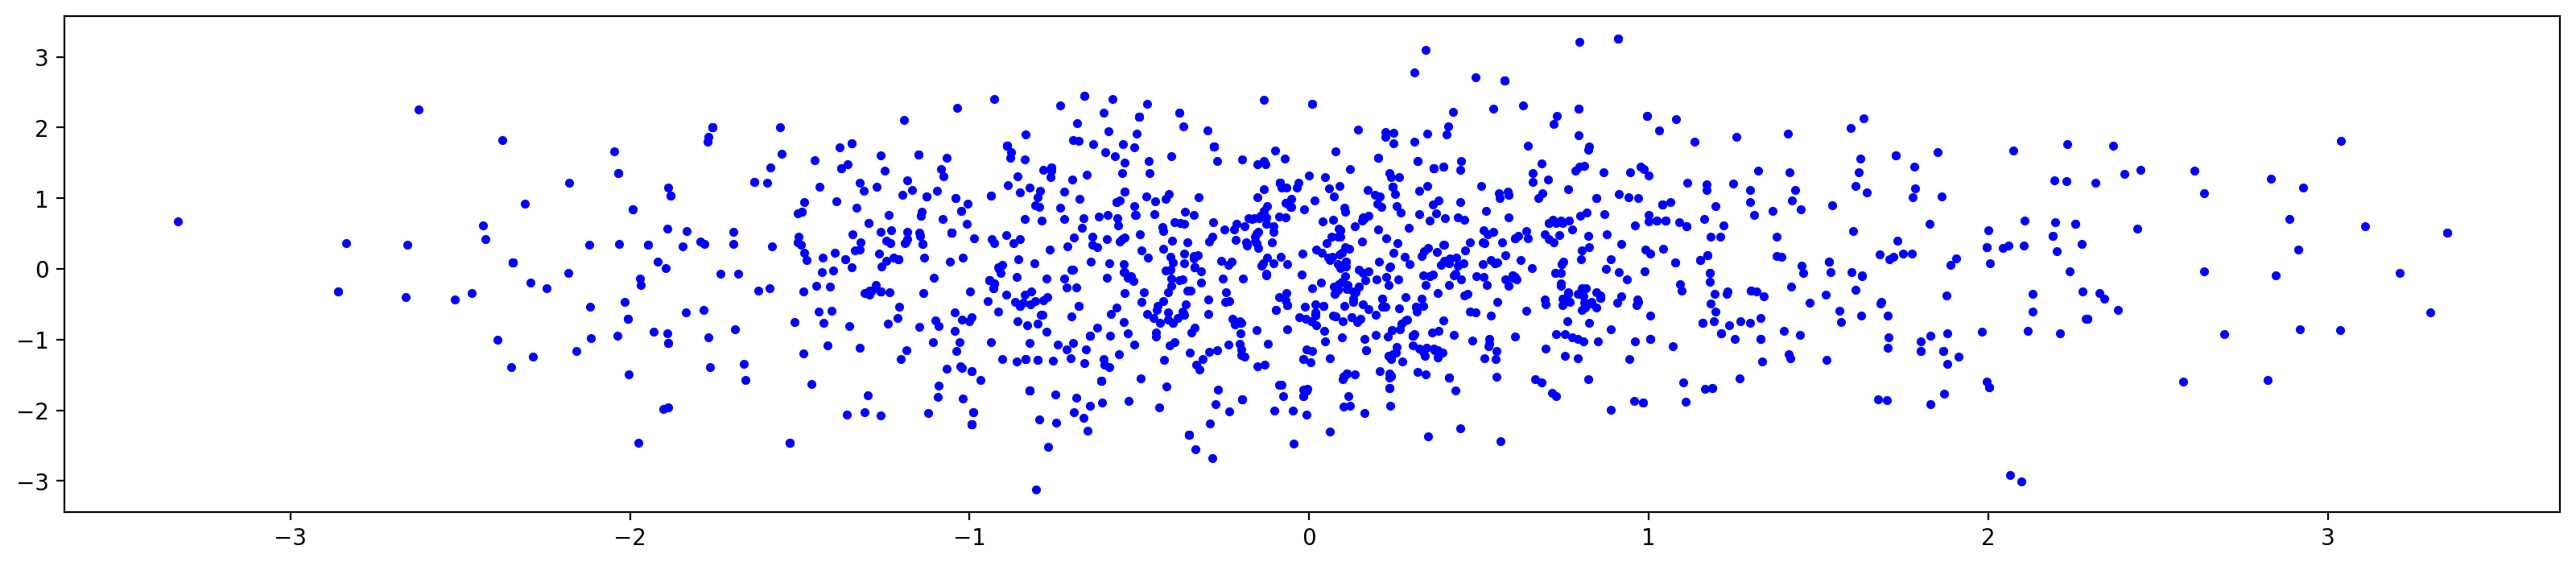

IndexError: index 4 is out of bounds for axis 1 with size 4

<Figure size 2000x400 with 0 Axes>

In [8]:
import numpy as np
from matplotlib import pyplot as plt

latentdata = autoencoder.encode(dataset.sequences)
sampling = np.array(latentdata[0])
print(sampling[:,0])

plt.figure(figsize=(20, 4))
plt.scatter(sampling[:,0], sampling[:,1], color='b', marker='.')
plt.show()

plt.figure(figsize=(20, 4))
plt.scatter(sampling[:,2], sampling[:,3], color='b', marker='.')
plt.show()

plt.figure(figsize=(20, 4))
plt.scatter(sampling[:,4], sampling[:,5], color='b', marker='.')
plt.show()

(1299, 1152)


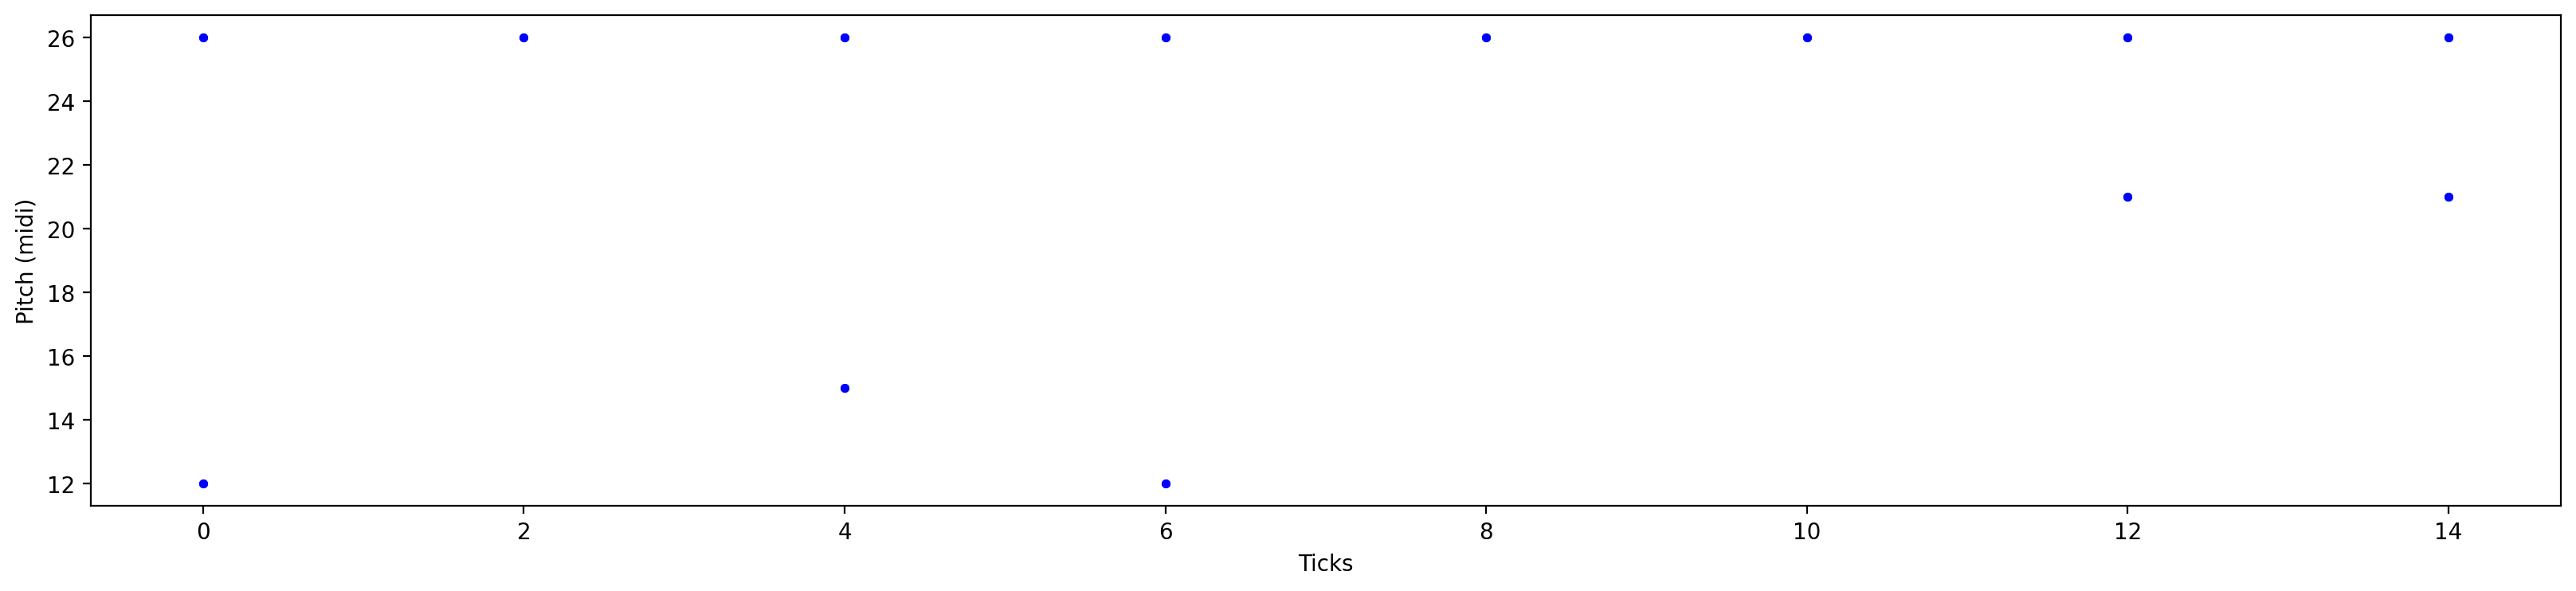

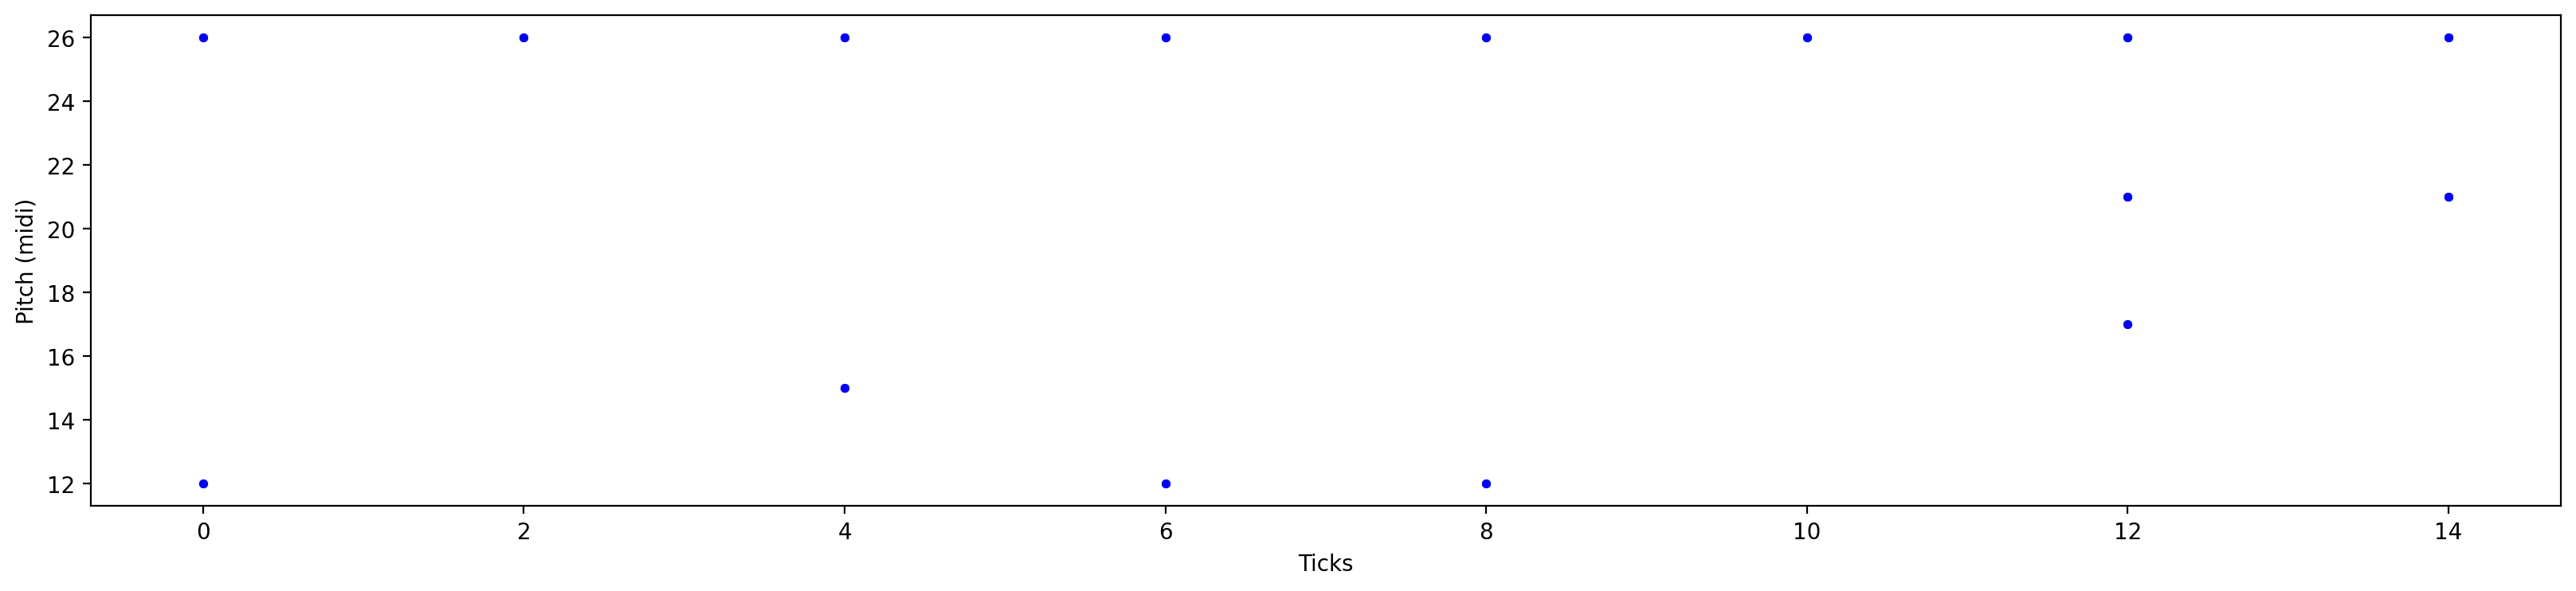

[1. 1. 1. ... 1. 1. 1.]


In [9]:
from xen.visualise import plotSparseNoteSequence

index = 4

print(output.shape)


plotSparseNoteSequence(codec.decode(dataset.sequences[index:index+1])[0])
plotSparseNoteSequence(codec.decode(output[index:index+1])[0], threshold = 0.5)


print(np.amax(output, axis = 1))

### Save Model

In [10]:
autoencoder.save()

INFO:tensorflow:Assets written to: /var/folders/5w/xlkmsvyj2tscz43jpx6j7qt00000gn/T/tmpegbqmrlk/assets
Model is 827896 bytes


2023-05-28 13:36:31.662326: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-28 13:36:31.662356: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-28 13:36:31.664558: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/5w/xlkmsvyj2tscz43jpx6j7qt00000gn/T/tmpegbqmrlk
2023-05-28 13:36:31.665879: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-28 13:36:31.665899: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/5w/xlkmsvyj2tscz43jpx6j7qt00000gn/T/tmpegbqmrlk
2023-05-28 13:36:31.671429: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-05-28 13:36:31.716971: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /var/folders/5w/xlkmsvyj2tscz43jpx6j7qt00000gn/T/tmpegbqmrlk
2023-05-